# Collision checking

As part of this exercise, you will write your very own collision checker. While this checker will only function in-simulation, it should give you a good idea of the complexity associated with detecting collisions in the real world.

We have defined a few data structures that you will use in this task.

## Data structures and protocol

The data structures are defined in the [`dt-protocols-daffy`](https://github.com/duckietown/dt-protocols) package.

In particular, you can look in [`collision_protocol.py`][file] the data structures to use.

We **strongly** suggest opening the [`collision_protocol.py`][file] link/file in a separate window, and cross-referencing the information given here with the code definition given in the file.

[file]: https://github.com/duckietown/dt-protocols/blob/daffy/src/dt_protocols/collision_protocol.py

The parameters for the collision checker is a `MapDefinition`, which specifies the `environment` and `body`. 
The `environment` is all of the shapes that the robot can collide with, and the `body` is all of the shapes that
make up the robot's body. Therefore, both `environment` and `body` are lists of `PlacedPrimitive`s. However, in
the validation tests, the robot list will only contain one `PlacedPrimitive`.

A `PlacedPrimitive` is a pair of a `FriendlyPose` and a `Primitive`, or a pose and a shape. Note that `theta_deg` in
`FriendlyPose` starts at zero in the positive x-axis direction and ends at 359 degrees, moving in a counter-clockwise 
direction.


```python
@dataclass
class PlacedPrimitive:
    pose: FriendlyPose
    primitive: Primitive
    
    
@dataclass
class FriendlyPose:
    x: float
    y: float
    theta_deg: float
```

A `FriendlyPose` is a handy pose representation containing a (x,y) coordinate along with an angle. How friendly!

A `Primitive` is either a `Rectangle` or a `Circle`. A circle's shape needs only be defined
by a `radius`, while a Rectangle is defined by four values:
 - `xmax` is the distance from the pose point to its side in the positive x direction (if theta_deg in `FriendlyPose` is zero, this side is on the right of the pose point).
 - `xmin` is the same, but in the negative x direction
 - `ymax` is the distance from the center point to its side in the positive y direction (if theta_deg in `FriendlyPose` is zero, this side is on the top of the pose point).
 - `ymin` is the same, but in the negative y direction
 
`xmax`, `xmin`, `ymax`, and `ymin` are all given with respect to the robot/obstacle's coordinate system, and not the world coordinate system. Therefore, the theta_deg value of the `FriendlyPose` affects the rotation of the Rectangle.

```python

@dataclass
class Circle:
    radius: float


@dataclass
class Rectangle:
    xmin: float
    ymin: float
    xmax: float
    ymax: float

Primitive = Union[Circle, Rectangle]
```

So, we represents shapes as the union of rototranslated `Rectangle`s and `Circle`s.

The class `CollisionChecker` in `collision_checker.py` first receives a message `MapDefinition` to define the environment and robot shape. It also contains a default pose for the robot (0, 0). Then, it recieves a sequence of `CollisionCheckQuery`s. The query contains a new pose for the robot, which you will need to cross-reference against the `MapDefinition` to detect collisions. 

Therefore, the `CollisionChecker` must take the new pose from the `CollisionCheckQuery`, combine it with the default pose already contained the the robot's `PlacedPrimitive`s, and then see if it collides with any part of the environment. The result of this will go into a `CollisionCheckResult`. The `CollisionCheckResult` contains only a boolean: true means that it is in collision, false means that it is not in collision.

## Template

In [`collision_checker.py`][file] you will find the template for the collision checker.

[file]: ./collision_checker.py

## Visualization

The challenge's output will be a series of images in a folder that is output at the end of the evaluation. The path will be something like:

`/tmp/![username]/duckietown/dt-challenges-runner/local-evals/mooc-collision-check-vali/![date]/step1/tmp/![random]/`

In the `images` folder you will see the queries with the ground truth,
as the image shows.

![query](media/env18.png)

Colors:

- $\color{blue}{\text{Blue}}$ is a pose in which the robot does not collide.
- $\color{red}{\text{Red}}$ is a pose in which the robot collides.

In the `results` folder you will see your results and the errors you made:

![result](media/env18-result.png)

The colors mean the following:

- $\color{blue}{\text{Blue}}$ is a pose in which the robot does not collide and you guessed **RIGHT**.
- $\color{orange}{\text{Orange}}$ is a pose in which the robot does not collide and you guessed **WRONG**.
- $\color{red}{\text{Red}}$ is a pose in which the robot collides and you guessed **RIGHT**.
- $\color{pink}{\text{Pink}}$ is a pose in which the robot collides and you guessed **WRONG**.

## Tips for implementing the collision checker

There are multiple ways to implement the collision checker. Here are some tips, but feel free to follow your intuition.

### Use decomposition

The first thing to note is that the problem can be *decomposed*.

You are asked to see whether the robot collides with the environment at a certain pose.
The robot is a list of `PlacedPrimitive`s and the environment is a list of `PlacedPrimitive`s. Remember, 
a `PlacedPrimitive` is the combination of a pose and a primitive, or in other terms, a location and
a shape. In pseudocode:

    robot =  rp1 ∪ rp2 ∪ rp3 ∪ ...
    environment =  obj1 ∪ obj2 ∪ obj3 ∪ ...

What you have to check is whether the intersection

    robot ∩ environment

is empty. By substituting terms we obtain:

    (rp1 ∪ rp2 ∪ ...) ∩ (obj1 ∪ obj2 ∪ ...)

Now, the intersection of unions is a union of intersection:

    [rp1 ∩ (wc1 ∪ wc2 ∪ ...)]  ∪  [rp2 ∩ (wc1 ∪ wc2 ∪ ...)] ∪ ...

The above shows that you have to check whether any primitive of the robot collides with environment.

Further expanding the first term we obtain:

    [rp1 ∩ (obj1 ∪ obj2 ∪ ...)] = (rp1 ∩ obj1) ∪ (rp2 ∩ obj2) ∪ ...

This shows that in the end, you can reduce to problem to checking pairwise intersection of `PlacedPrimitives`. 
Therefore, using *decomposition*, we have simplified the problem of "Does the robot collide with 
the environment?" to asking "Does this part of the robot collide with this environmental object?". We ask
this second question multiple times for each query. If the answer to this second question is ever yes, then 
we know that the robot collides with the environment.

This tip has already been partially implemented in `collision_checker.py`.
In other words...

```
for each environment_shape in env:
    for each robot_part in robot:
        if collides:
            return True
return False
```

### Pay attention to the poses

Both robot and environment are lists of `PlacedPrimitives`.

That is, we should rewrite the robot expression as:

    robot = RT(pose1, primitive1) ∪ RT(pose2, primitive1) ∪ ...

where `RT()` rototranslates a primitive by a pose. Also note that for each query the robot changes pose. Let's call this pose `Q`. Note that we have:

Note that we have

    robot at pose Q = RT(Q * pose1, primitive1) ∪ RT(Q * pose2, primitive1) ∪ ... 

where `Q * pose` represent matrix multiplication.

The above says that you can "push inside" the global pose.

### In the end, what is the core complexity?

Following the above tips, you should be able to get to the point where you are left with checking the collision of two rototranslated primitives.

Now notice that there are 3 cases:

- `Circle` vs `Circle`
- `Rectangle` vs `Circle`
- `Rectangle` vs `Rectangle`


Note that without loss of generality you can get to the point where you have one primitive at the origin (You put one primitive in the coordinate frame of the other). How would you go about it?

`Circle` vs `Circle` is easy: two circles intersects if the distance of the centers is less than the sum of the radii. (The validation tests don't actually ever use a circle shape on a robot, so this case may seem unncessary, but it's useful to leave it in for learning purposes).

For the others, you have to think about it... Use your robotic mind to engineer a solution!

### Speeding things up using lower/upper bound heuristics

If you want to speed things up, consider the following method, which allows to introduce a fast heuristic phase using only circle-to-circle comparisons.

For each rectangle `R`, you can find `C1`, the largest circle that is contained in the rectangle, and `C2`, the smallest circle that contains the rectangle. These are an upper bound and a lower bound to the shape.

    C1 ⊆ R ⊆ C2

Now notice that:

- if `C1` collides with a shape, also `R` does.  (but if it doesn't you cannot conclude anything)
- if `C2` does not collide with a shape, `R` does not as well. (but if it does, you cannot conclude anything)

Using this logic, you can implement a method that first checks quickly whether the circle approximations give already enough information to conclude collision/no-collision. Only if the first test is inconclusive you go to the more expensive component.

### Speeding things up using bitmaps heuristics

Another approach is using bitmaps to convert the environment to an image, where a black pixel means "occupied", and a white pixel means "free". 

Then you can do the same with the robot shape and obtain another bitmap.

Then you check whether the two bitmaps intersect

Advantages:

- reduces the problem of collision to drawing of shapes;
- cheaper if shapes are very complex.

Disadvantages:

- There are subtle issues regarding the approximations you are making. What exactly does a pixel represent? is it a point, or is it an area? is this an optimistic or pessimistic approximation? The semantics of painting is unclear. 

In [31]:
# import numpy as np
# from scipy.spatial.transform import Rotation as R
# R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
# import numpy as np
# theta_deg = 45
# thera_r = np.radians(theta_deg)
# c, s = np.cos(thera_r), np.sin(thera_r)
# R = np.array(((c, -s), (s, c)))
# lp = np.array([[0.70710678],[0.70710678]])
# cp_at_w = np.array([[1],[0]])
# wp = c + R@lp
# wp


# wrec = {}

# lps = [np.array([[0.70710678], [0.70710678]]),
#        np.array([[-0.70710678], [0.70710678]]),
#        np.array([[-0.70710678], [-0.70710678]]),
#        np.array([[0.70710678], [-0.70710678]]),]
# pose_at_w = np.array([[1],[2]])

# thera_r = np.radians(45)
# c, s = np.cos(thera_r), np.sin(thera_r)
# R = np.array(((c, -s), (s, c)))
# # wp = c + R@lp
# wvs = [(pose_at_w + R@lp).flatten() for lp in lps]
# wrec["wvs"] = wvs

# geo_c_at_w = ((wvs[0] + wvs[2]) / 2).flatten()

# geo_c_at_w
# wvs

# np.sqrt(((wvs[0] - wvs[2])**2).sum())/2
# wvs

array([1., 2.])

In [59]:
# A = np.array([-1,0])
# B = np.array([1,0])
# C = np.array([0,1])
# # D = np.array([0,-1])
# # D = np.array([0,0])
# D = np.array([0,1])
# AB = B - A
# AC = C - A
# AD = D - A
# np.dot(np.cross(AB,AC), np.cross(AB,AD))

4

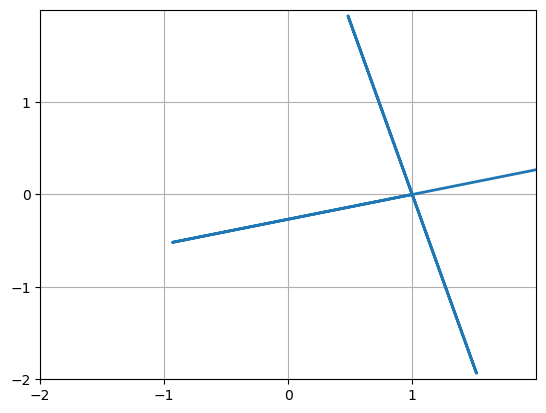

In [53]:
# theta_deg = 15

# import matplotlib.pyplot as plt
# import numpy as np

# class cir:
#     x: float
#     y: float
#     r: float

# class rec:
#     x: float
#     y: float
#     width: float
#     height:float
    

# c1 = cir()
# c1.x = 0
# c1.y = 0
# c1.r = 1

# r1 = rec()
# r1.x = 0
# r1.y = 0
# r1.width = 2
# r1.height = 2

# lp = np.array([[2],[0]])
# # print(c1.x, c1.y)
# pose_at_w = np.array([[1],[0]])
# Rs = []

# for deg_step in [0,90,180,270]:
#     thera_r = np.radians(theta_deg + deg_step)
#     c, s = np.cos(thera_r), np.sin(thera_r)
#     R = np.array(((c, -s), (s, c)))
#     Rs.append(R)
# # wp = c + R@lp
# wvs = [(pose_at_w + Rn@lp).flatten() for Rn in Rs]
# wvs

# x, y = [],[]
# for ele in wvs:
#     x.append(ele[0])
#     x.append(pose_at_w[0][0])
#     y.append(ele[1])
#     y.append(pose_at_w[1][0])

# fig, ax = plt.subplots()

# ax.plot(x, y, linewidth=2.0)

# ax.set(xlim=(-2, 2), xticks=np.arange(-2, 2),
#        ylim=(-2, 2), yticks=np.arange(-2, 2))

# plt.grid()
# plt.show()

In [52]:
# na1 = np.array([1,2])
# na1.reshape(2,1)

array([[1],
       [2]])

In [56]:
# if not 1==2:
#     print("here")
# else:
#     print("here 2")

here


In [57]:
# l1 = [1,2,3]
# l1.append(l1[-1])
# l1

[1, 2, 3, 3]

In [58]:
# for i in range(4):
#     print(i)

0
1
2
3
